In [1]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Téléchargement des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to C:\Users\hajja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hajja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\hajja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Chargement du dataset complet
df = pd.read_csv('../data/raw/dataset_marrakech_english.csv')  # ou X_train + y_train concat
df = df[['review', 'sentiment_label']].dropna().reset_index(drop=True)

print(f"Taille du dataset : {df.shape}")
df.head()


Taille du dataset : (6282, 2)


,review,sentiment_label
0,Just got back from Marrakech and I'm still ree...,Positive
1,"Meh, Jemaa el-Fna square was okay, I guess. To...",Neutral
2,The architecture in Marrakech is literally wow...,Positive
3,Got scammed by a taxi driver near Majorelle Ga...,Negative
4,"The locals were so friendly and welcoming, it ...",Positive


In [11]:
# Chargement des splits existants
X_train = pd.read_csv('../data/processed/X_train.csv')['review']
X_test = pd.read_csv('../data/processed/X_test.csv')['review']
y_train = pd.read_csv('../data/processed/y_train.csv')['sentiment_label']
y_test = pd.read_csv('../data/processed/y_test.csv')['sentiment_label']

# Prétraitement sur X_train et X_test
def clean_text(text):
    import re
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    import emoji
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

X_train_clean = X_train.astype(str).apply(clean_text)
X_test_clean = X_test.astype(str).apply(clean_text)


In [12]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train_clean)
X_test_tfidf = vectorizer.transform(X_test_clean)

print(f"Shape TF-IDF train: {X_train_tfidf.shape}")


Shape TF-IDF train: (5025, 5000)


In [13]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)


In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8886

Classification Report:

              precision    recall  f1-score   support

    Negative       0.87      0.78      0.82       244
     Neutral       0.83      0.79      0.81       345
    Positive       0.92      0.98      0.95       668

    accuracy                           0.89      1257
   macro avg       0.87      0.85      0.86      1257
weighted avg       0.89      0.89      0.89      1257



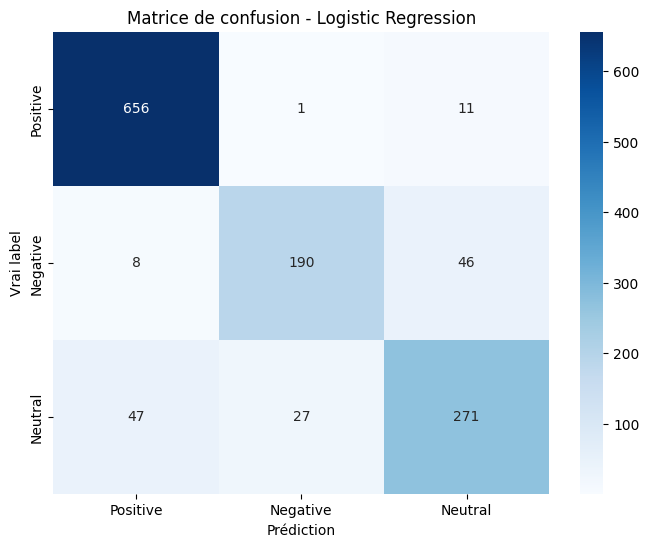

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=['Positive', 'Negative', 'Neutral'])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative', 'Neutral'],
            yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title("Matrice de confusion - Logistic Regression")
plt.xlabel("Prédiction")
plt.ylabel("Vrai label")
plt.show()


In [17]:
import joblib

joblib.dump(model, '../models/logreg_sentiment_model.pkl')
joblib.dump(vectorizer, '../models/tfidf_vectorizer.pkl')

print("Modèle et TF-IDF sauvegardés !")


Modèle et TF-IDF sauvegardés !


In [18]:
# Création d'un DataFrame avec les prédictions sur le test set
df_test_results = pd.DataFrame({
    'review': X_test,
    'true_sentiment': y_test,
    'predicted_sentiment': y_pred  # y_pred = predictions du modèle From Scratch sur X_test
})

# Sauvegarde dans un CSV
df_test_results.to_csv('../data/processed/results_fromscratch_test.csv', index=False)
print("Prédictions From Scratch sur le test set sauvegardées dans data/processed/results_fromscratch_test.csv")


Prédictions From Scratch sur le test set sauvegardées dans data/processed/results_fromscratch_test.csv
